# Modelling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier)
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_rows', 400)
pd.set_option('max_colwidth', 120)
pd.set_option('display.max_columns', None)

In [3]:
train = pd.read_csv('./datasets/train_processed.csv')
train = train._get_numeric_data().drop(columns='n_comments', errors='ignore')

In [4]:
test = pd.read_csv('./datasets/test_processed.csv')
test = test._get_numeric_data()

In [5]:
full = pd.read_csv('./datasets/full_processed.csv')

In this notebook, we'll carry out of the following steps

- Run a Train-Test-Split on our data
- Run data through a pipeline and fit various models to our training data
- Select the best model and tune hyper-parameters
- Evaluate model based on accuracy and ROC-AUC

We'll look to test a range of classification techniques including Logistic Regression, Random Forest, Boosting, Multinomial Naive Bayes classification and Support Vector Machine (SVM) classification.

Accuracy and ROC-AUC will be our main metrics -- we want to minimize both false negatives and false positives, but we also want to know how good our models are at separating our positive and negative class.

It's worth noting that in previous iterations of my modelling I tried modelling with purely text-based features (headline + abstract). This returned an unsatisfactory accuracy and ROC-AUC score.

## Train Test Split

In [6]:
X = train.drop(columns=['is_popular'])
y = train['is_popular']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Instantiate Models

In [8]:
feature_names = X_train.columns

In [9]:
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
          'xgb': xgb.XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc'),
        }

## Model Function Setup

To get various feature importance scores from XGBoost, I created a custom transformer that scales all features with StandardScaler and returns it as a dataframe (instead of an array).

In [10]:
class CustomTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# This function takes a dataframe as input and returns a scaled version
def scale_df(input_df):
    ss = StandardScaler()
    feature_names = input_df.columns
    input_df = ss.fit_transform(input_df)
    input_df = pd.DataFrame(input_df, columns=feature_names)
    return input_df

In [11]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', CustomTransformer(scale_df)),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs.best_estimator_
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe[1])
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

## Initial Run

In [12]:
lr = run_model('lr')

### METRICS ###


{'model': 'lr',
 'train_auc': 0.8441526452636806,
 'test_auc': 0.848308634620144,
 'precision': 0.7834254143646409,
 'specificity': 0.7998979070954568,
 'recall': 0.7546567323044172,
 'f_score': 0.7687720249390079}

True Negatives: 1567
False Positives: 392
False Negatives: 461
True Positives: 1418


In [13]:
rf = run_model('rf')

### METRICS ###


{'model': 'rf',
 'train_auc': 1.0,
 'test_auc': 0.8665311857419843,
 'precision': 0.7942318358291736,
 'specificity': 0.810617662072486,
 'recall': 0.7621075039914849,
 'f_score': 0.7778381314502987}

True Negatives: 1588
False Positives: 371
False Negatives: 447
True Positives: 1432


In [14]:
et = run_model('et')

### METRICS ###


{'model': 'et',
 'train_auc': 1.0,
 'test_auc': 0.8685890722558594,
 'precision': 0.7875275938189845,
 'specificity': 0.8034711587544666,
 'recall': 0.7594465141032464,
 'f_score': 0.7732321863993498}

True Negatives: 1574
False Positives: 385
False Negatives: 452
True Positives: 1427


In [15]:
gb = run_model('gb')

### METRICS ###


{'model': 'gb',
 'train_auc': 0.877682750961473,
 'test_auc': 0.8650679808886864,
 'precision': 0.7859858772406301,
 'specificity': 0.7988769780500256,
 'recall': 0.7700904736562001,
 'f_score': 0.7779569892473118}

True Negatives: 1565
False Positives: 394
False Negatives: 432
True Positives: 1447


In [16]:
svc = run_model('svc')

### METRICS ###


{'model': 'svc',
 'train_auc': 0.8885165314480307,
 'test_auc': 0.8527667095630733,
 'precision': 0.7967064168086314,
 'specificity': 0.8172537008677897,
 'recall': 0.746673762639702,
 'f_score': 0.7708791208791208}

True Negatives: 1601
False Positives: 358
False Negatives: 476
True Positives: 1403


In [17]:
ada = run_model('ada')

### METRICS ###


{'model': 'ada',
 'train_auc': 0.8517299029883305,
 'test_auc': 0.8485251541649041,
 'precision': 0.7730769230769231,
 'specificity': 0.7891781521184278,
 'recall': 0.7488025545502927,
 'f_score': 0.7607461476074615}

True Negatives: 1546
False Positives: 413
False Negatives: 472
True Positives: 1407


In [18]:
xgb = run_model('xgb')

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9934760781132403,
 'test_auc': 0.8606760571492064,
 'precision': 0.7783902976846747,
 'specificity': 0.7947932618683001,
 'recall': 0.7514635444385311,
 'f_score': 0.7646899539669645}

True Negatives: 1557
False Positives: 402
False Negatives: 467
True Positives: 1412


In [19]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,et,1.000000,0.868589,0.787528,0.803471,0.759447,0.773232
1,rf,1.000000,0.866531,0.794232,0.810618,0.762108,0.777838
2,gb,0.877683,0.865068,0.785986,0.798877,0.770090,0.777957
3,xgb,0.993476,0.860676,0.778390,0.794793,0.751464,0.764690
4,svc,0.888517,0.852767,0.796706,0.817254,0.746674,0.770879
5,ada,0.851730,0.848525,0.773077,0.789178,0.748803,0.760746
6,lr,0.844153,0.848309,0.783425,0.799898,0.754657,0.768772


## Hyperparameter Tuning

### Logistic Regression

In [20]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],
    
    'lr__l1_ratio':[0, 0.5, 1],

     # Trying different alphas of: 10, 1, 0.1  (C = 1/alpha)
    'lr__C':[0.1, 1, 10],
}

In [21]:
lr_gs = run_model('lr', mod_params=lr_params, grid_search=True)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    6.8s finished
C:\Users\benja\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


### BEST PARAMS ###


LogisticRegression(C=1, l1_ratio=0, max_iter=5000, penalty='l1',
                   random_state=42, solver='saga')

### METRICS ###


{'model': 'lr',
 'train_auc': 0.8441560877822272,
 'test_auc': 0.8483385181206755,
 'precision': 0.7838584853510226,
 'specificity': 0.8004083716181726,
 'recall': 0.7546567323044172,
 'f_score': 0.7689804772234274}

True Negatives: 1568
False Positives: 391
False Negatives: 461
True Positives: 1418


### SVC

In [22]:
svc_params = {
    'svc__C':[0.05, 1],
    'svc__gamma':[0.05, 0.1], 
    'svc__kernel':['rbf', 'sigmoid'],
}

In [23]:
svc_gs =  run_model('svc', mod_params=svc_params, grid_search=True)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   15.9s finished


### BEST PARAMS ###


SVC(C=1, gamma=0.05, probability=True, random_state=42)

### METRICS ###


{'model': 'svc',
 'train_auc': 0.9051034339621418,
 'test_auc': 0.8490527337833789,
 'precision': 0.788826815642458,
 'specificity': 0.8070444104134763,
 'recall': 0.7514635444385311,
 'f_score': 0.7696920141727991}

True Negatives: 1581
False Positives: 378
False Negatives: 467
True Positives: 1412


### Random Forest

In [24]:
rf_params = {'rf__n_estimators': [100, 200],
             'rf__max_depth': [20, 25, 30, 40],
             'rf__min_samples_leaf': [2, 3, 4],
            }

In [25]:
rf_gs =  run_model('rf', mod_params=rf_params, grid_search=True)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   10.3s finished


### BEST PARAMS ###


RandomForestClassifier(max_depth=20, min_samples_leaf=3, n_estimators=200,
                       random_state=42)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9912806493288461,
 'test_auc': 0.8696699041364471,
 'precision': 0.7928767123287671,
 'specificity': 0.8070444104134763,
 'recall': 0.7700904736562001,
 'f_score': 0.781317494600432}

True Negatives: 1581
False Positives: 378
False Negatives: 432
True Positives: 1447


### Extra Trees

In [26]:
et_params = {'et__n_estimators': [100, 200],
             'et__max_depth': [20, 25, 30, 35, 40, 50],
             'et__min_samples_leaf': [2, 3, 4],
            }

In [27]:
et_gs =  run_model('et', mod_params=et_params, grid_search=True)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    9.7s finished


### BEST PARAMS ###


ExtraTreesClassifier(max_depth=40, min_samples_leaf=2, n_estimators=200,
                     random_state=42)

### METRICS ###


{'model': 'et',
 'train_auc': 0.9988750448088691,
 'test_auc': 0.8728125617196161,
 'precision': 0.7961538461538461,
 'specificity': 0.810617662072486,
 'recall': 0.7711548696114955,
 'f_score': 0.7834549878345498}

True Negatives: 1588
False Positives: 371
False Negatives: 430
True Positives: 1449


### Adaptive Boosting

In [28]:
ada_params = {'ada__n_estimators': [500],
              'ada__learning_rate': [0.05, 0.1, 0.2, 0.9],
             }

In [29]:
ada_gs = run_model('ada', mod_params=ada_params, grid_search=True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    4.3s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.5s finished


### BEST PARAMS ###


AdaBoostClassifier(learning_rate=0.1, n_estimators=500, random_state=42)

### METRICS ###


{'model': 'ada',
 'train_auc': 0.851758141618727,
 'test_auc': 0.8482246891504692,
 'precision': 0.786368843069874,
 'specificity': 0.8095967330270546,
 'recall': 0.7307078233102714,
 'f_score': 0.7575172413793104}

True Negatives: 1586
False Positives: 373
False Negatives: 506
True Positives: 1373


### Gradient Boosting

In [30]:
gb_params = {'gb__n_estimators': [500, 1000],
             'gb__learning_rate': [0.1, 0.2, 0.3],
}

In [31]:
gb_gs = run_model('gb', mod_params=gb_params, grid_search=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   15.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   22.3s finished


### BEST PARAMS ###


GradientBoostingClassifier(n_estimators=500, random_state=42)

### METRICS ###


{'model': 'gb',
 'train_auc': 0.931495527345197,
 'test_auc': 0.8660295504353347,
 'precision': 0.7862554112554112,
 'specificity': 0.7983665135273098,
 'recall': 0.7732836615220862,
 'f_score': 0.7797155889455325}

True Negatives: 1564
False Positives: 395
False Negatives: 426
True Positives: 1453


### XGBoost

In [32]:
xgb_params = { 
              'xgb__learning_rate' : [0.05, 0.1, 0.3],
              'xgb__max_depth' : [6, 7], 
              'xgb__n_estimators' : [100, 150],
              'xgb__reg_alpha' : [0, 1, 2],
              'xgb__reg_lambda' : [0, 1, 2],
              'xgb__gamma' : [0, 1, 3],
             }

In [33]:
xgb_gs = run_model('xgb', mod_params=xgb_params, grid_search=True)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  3.3min finished


### BEST PARAMS ###


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.91806184709081,
 'test_auc': 0.8727219603793683,
 'precision': 0.7916666666666666,
 'specificity': 0.8034711587544666,
 'recall': 0.778605641298563,
 'f_score': 0.7850818352562383}

True Negatives: 1574
False Positives: 385
False Negatives: 416
True Positives: 1463


## ROC-AUC Evaluation

In [34]:
gs_df = pd.DataFrame(gs_list)
gs_df.sort_values(by='test_auc', ascending=False)

,model,train_auc,test_auc,precision,specificity,recall,f_score
3,et,0.998875,0.872813,0.796154,0.810618,0.771155,0.783455
6,xgb,0.918062,0.872722,0.791667,0.803471,0.778606,0.785082
2,rf,0.991281,0.869670,0.792877,0.807044,0.770090,0.781317
5,gb,0.931496,0.866030,0.786255,0.798367,0.773284,0.779716
1,svc,0.905103,0.849053,0.788827,0.807044,0.751464,0.769692
0,lr,0.844156,0.848339,0.783858,0.800408,0.754657,0.768980
4,ada,0.851758,0.848225,0.786369,0.809597,0.730708,0.757517


In [35]:
gs_dict = {
    xgb_gs: 'XGBoostClassifier',
    et_gs: 'ExtraTreeClassifier',
    rf_gs: 'RandomForest',
    gb_gs: 'GradientBoostingClassifier',
    svc_gs: 'SupportVectorMachineClf',
    lr_gs: 'LogisticRegression',
    ada_gs: 'AdaBoostClassifier',
}

In [36]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('gray')
                axes[a].line_.set_alpha(0.25)
                
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

Performance is pretty close between our ensemble tree models and XGBoost -- we can see that XGBoost has a TPR of 0.8 to a FPR of roughly 0.21.

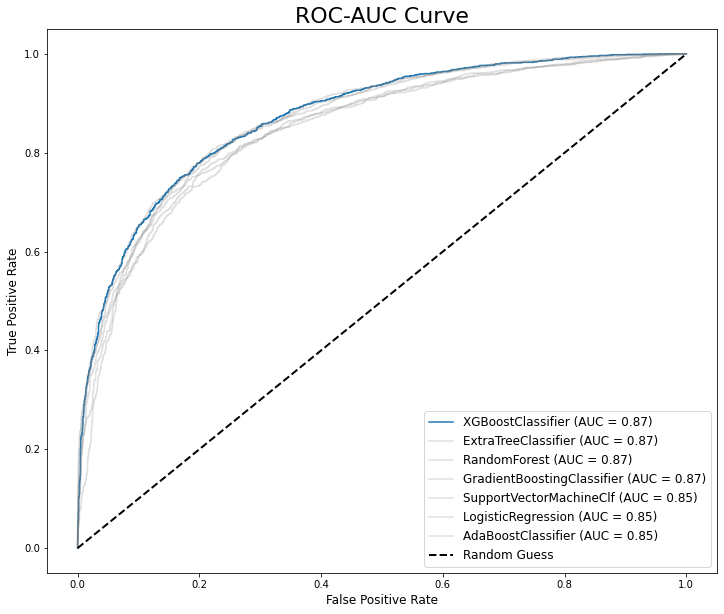

In [37]:
roc_curve_plotter(gs_dict, True)

## Testing against unseen data

At this point, we're taking our data and testing it on "unseen" data, or the test set that we earlier created. 

In [38]:
final_actual = test['is_popular']

In [39]:
test = test.drop(columns=['is_popular'])

In [40]:
def evaluate_model(model):
    final_proba = model.predict_proba(test)
    final_proba = final_proba[:, 1]
    final_preds = model.predict(test)
    print(f'Accuracy:', f'{accuracy_score(final_actual, final_preds):.3f}')
    print(f'Precision:', f'{precision_score(final_actual, final_preds):.3f}')
    print(f'Recall:', f'{recall_score(final_actual, final_preds):.3f}')
    print(f'ROC-AUC:', f'{roc_auc_score(final_actual, final_proba):.3f}')

In [41]:
evaluate_model(xgb_gs)

Accuracy: 0.782
Precision: 0.768
Recall: 0.787
ROC-AUC: 0.865


In [42]:
evaluate_model(rf_gs)

Accuracy: 0.784
Precision: 0.775
Recall: 0.781
ROC-AUC: 0.864


In [43]:
evaluate_model(et_gs)

Accuracy: 0.778
Precision: 0.777
Recall: 0.760
ROC-AUC: 0.866


#### Refit models on entire dataset

In [44]:
xgb_gs.fit(X, y)
rf_gs.fit(X, y)
et_gs.fit(X, y);

Performance for our top models is pretty close -- but looks like XGBoost wins. It has the highest accuracy and AUC-ROC score.

In [45]:
evaluate_model(xgb_gs)

Accuracy: 0.786
Precision: 0.775
Recall: 0.785
ROC-AUC: 0.869


In [46]:
evaluate_model(rf_gs)

Accuracy: 0.781
Precision: 0.772
Recall: 0.776
ROC-AUC: 0.866


In [47]:
evaluate_model(et_gs)

Accuracy: 0.779
Precision: 0.780
Recall: 0.756
ROC-AUC: 0.866


### Misclassification Analysis

In [48]:
final_proba = rf_gs.predict_proba(test)
final_proba = final_proba[:, 1]
final_preds = rf_gs.predict(test)

In [49]:
predictions = pd.DataFrame(data=[final_actual, final_preds, final_proba]).T
predictions.columns = ['actual', 'predicted', 'proba']

In [50]:
predictions

,actual,predicted,proba
0,1.0,1.0,0.969706
1,1.0,1.0,0.988791
2,1.0,1.0,0.908532
3,1.0,1.0,0.994417
4,0.0,0.0,0.234660
...,...,...,...
3990,1.0,1.0,0.847033
3991,0.0,0.0,0.081849
3992,1.0,1.0,0.519875
3993,1.0,0.0,0.321361


In [51]:
wrong_predictions = predictions[predictions['actual'] != predictions['predicted']]

In [52]:
init_test = pd.read_pickle('./datasets/test.pickle').reset_index(drop=True)

In [53]:
wrong_predictions = pd.merge(wrong_predictions, init_test, left_index=True, right_index=True)

In [54]:
wrong_predictions = wrong_predictions[['actual', 'predicted', 'proba', 'newsdesk', 'section', 'subsection',
                                       'headline', 'abstract', 'keywords']]

In [55]:
# 1 = false positives, 0 = false negatives
wrong_predictions['actual'].value_counts()

0.0    442
1.0    432
Name: actual, dtype: int64

In [56]:
# Looking at false positives
wrong_predictions[wrong_predictions['proba'] > 0.80].head(10).sort_values(by='proba', ascending=False)

,actual,predicted,proba,newsdesk,section,subsection,headline,abstract,keywords
254,0.0,1.0,0.937960,OpEd,Opinion,NaN,What We Can Learn From the Rise and Fall of ‘Political Blackness’,"Before “people of color” and BIPOC, Britain had its own inclusive concept for nonwhite people.","[Black People, Blacks, Race and Ethnicity, Minorities, Great Britain, Politics and Government]"
66,0.0,1.0,0.931563,Politics,U.S.,Politics,Democrats Mount an All-Out Effort to Get Detroit to Vote,"Urgently trying to avoid a repeat of 2016, when Donald Trump won Michigan by a razor-thin margin, Democrats have bee...","[Presidential Election of 2020, Black People, Blacks, Biden, Joseph R Jr, Harris, Kamala D, Trump, Donald J, Detroit..."
321,0.0,1.0,0.844512,Washington,U.S.,Politics,"Under Pence, Politics Regularly Seeped Into the Coronavirus Task Force","In taking a leading role in managing the White House’s response to the pandemic, the vice president and his team had...","[Pence, Mike, Coronavirus (2019-nCoV), United States Politics and Government, Presidential Election of 2020, Trump, ..."
190,0.0,1.0,0.837098,The Upshot,The Upshot,NaN,The Pandemic Has Hindered Many of the Best Ideas for Reducing Violence,That may be one part of this year’s rise in violent crime.,"[Crime and Criminals, Therapy and Rehabilitation, Nonprofit Organizations, Shutdowns (Institutional), Coronavirus (2..."
318,0.0,1.0,0.829171,Metropolitan,New York,NaN,Their Buzzy Off Broadway Play Shut Down. Here’s What They Did Next.,"When the virus forced New York theater to go dark, it upended thousands of lives, from actors to ticket takers. An a...","[Theater, New York City, Playwrights Horizons, Greenfield, Adam, Khoury, Sylvia, Selling Kabul (Play), Quarantine (L..."
227,0.0,1.0,0.826981,OpEd,Opinion,NaN,One Woman’s Revenge Against the Nazis,Her actions have become legend in a small Czech town.,"[World War II (1939-45), Holocaust and the Nazi Era, Czech Republic, Documentary Films and Programs, Sex Crimes, Syp..."
423,0.0,1.0,0.821369,Washington,U.S.,Politics,Parties Offer Divergent Portraits of Barrett as Senate Opens Hearings,"Democrats will portray President Trump’s Supreme Court nominee as an ideologue, while Republicans will paint her as ...","[Barrett, Amy Coney, Supreme Court (US), Appointments and Executive Changes, United States Politics and Government, ..."
426,0.0,1.0,0.808347,Washington,U.S.,Politics,Trump’s Virus Treatment Revives Questions About Unchecked Nuclear Authority,"Even before the president was given mood-altering drugs, there was a movement to end the commander in chief’s sole a...","[Trump, Donald J, White House Coronavirus Outbreak (2020), Coronavirus (2019-nCoV), Dexamethasone (Drug), Twenty-Fif..."
69,0.0,1.0,0.803129,Washington,U.S.,Politics,Peace Corps Faces Questions Over Another Volunteer Death,A 24-year-old volunteer died of undiagnosed malaria on the island nation of Comoros. It was one of at least three de...,"[Volunteers and Community Service, United States Politics and Government, Peace Corps, Castle, Nicholas Matthew (199..."
462,0.0,1.0,0.800225,Foreign,World,Asia Pacific,"‘We Were Bulletproof’: As Child Soldiers Grow Up, Legacy of War Lingers","Twin leaders of Myanmar’s God’s Army were once thought to have magical powers. Now adults, they are contending with ...","[Child Soldiers, Myanmar, Refugees and Displaced Persons, Karen National Union, Defense and Military Forces, God's A..."


In [57]:
# Looking at false negatives
wrong_predictions[wrong_predictions['proba'] < 0.4].head(10).sort_values(by='proba')

,actual,predicted,proba,newsdesk,section,subsection,headline,abstract,keywords
34,1.0,0.0,0.094006,Weekend,Arts,Music,The Special Place Where Ella Fitzgerald Comes Alive,The singer’s concert recordings have always had a power that her studio outings could only imply. “Ella: The Lost Be...,"[Jazz, Fitzgerald, Ella, Ella: The Lost Berlin Tapes (Album)]"
50,1.0,0.0,0.105682,RealEstate,Real Estate,NaN,Real Estate Sales Continue to Stagnate in Manhattan,The number of apartments sold in the last three months was down by 46 percent compared to the same period in 2019.,"[Real Estate and Housing (Residential), Quarantine (Life and Culture), Shutdowns (Institutional), Condominiums, Manh..."
33,1.0,0.0,0.237722,Well,Well,Live,Where You Carry Body Fat May Affect How Long You Live,Extra weight in some places may lower your risk of dying prematurely.,"[Weight, Deaths (Fatalities)]"
60,1.0,0.0,0.247927,Styles,Style,NaN,‘Ridicule’: The French Reaction to ‘Emily in Paris’,Darren Star’s latest serial goes down like sour wine for actual Parisians.,"[Television, Emily in Paris (TV Program), Paris (France), your-feed-fashion]"
17,1.0,0.0,0.298873,Well,Well,Mind,Laughter May Be Effective Medicine for These Trying Times,"Doctors, nurses and therapists have a prescription for helping all of us to get through these difficult times: Try a...","[Content Type: Service, Anxiety and Stress, Laughter, Comedy and Humor, Emergency Medical Treatment, Hospitals, Coro..."
98,1.0,0.0,0.340034,Summary,Times Insider,NaN,Following Falsehoods: A Reporter’s Approach on QAnon,"Kevin Roose, a Times tech columnist, has watched the baseless conspiracy theory grow from fringe internet subculture...","[QAnon, Conspiracy Theories, News and News Media, Rumors and Misinformation, Fringe Groups and Movements, Trump, Don..."
28,1.0,0.0,0.349069,TStyle,T Magazine,NaN,"On Long Island, a Beachfront Haven for Black Families","In the 1930s, a group of trailblazing African-Americans bought plots for themselves in Sag Harbor, establishing a cl...","[Black People, Blacks, Sag Harbor (NY), Families and Family Life, Historic Buildings and Sites, Real Estate and Hous..."
19,1.0,0.0,0.353092,Dining,Food,"Wine, Beer & Cocktails","Jim Murray, a Top Whiskey Critic, Faces Accusations of Sexism","Several distillers and retailers have severed ties to the British writer, after complaints surfaced about the treatm...","[Whiskey, Murray, Jim (1957- ), Discrimination, Women and Girls, Jim Murray's Whisky Bible (Book), Books and Literat..."
76,1.0,0.0,0.381530,Science,Health,NaN,Trump Has the Coronavirus. What Risks Does He Face?,"Older men have a greater chance of becoming severely ill from Covid-19, though many recover quickly. Experts say the...","[Trump, Donald J, United States, Presidential Election of 2020, Coronavirus (2019-nCoV), Dexamethasone (Drug), Obesi..."
102,1.0,0.0,0.384231,Express,World,Europe,Arctic Expedition’s Dress Code Raises Concerns About Sexism in Science,"The scientific institute leading the trip denied that its policy had been applied to a specific sex, saying, “Women ...","[Wegener, Alfred, Institute for Polar and Marine Research, Science and Technology, Research, Workplace Hazards and V..."


### Correct Prediction Analysis

In [58]:
predictions = pd.merge(predictions, init_test, left_index=True, right_index=True)

In [59]:
predictions = predictions[['actual', 'predicted', 'proba', 'newsdesk', 'section', 'subsection',
                                       'headline', 'abstract', 'keywords']]

In [60]:
predictions.sort_values(by='proba', ascending=False).head(5)

,actual,predicted,proba,newsdesk,section,subsection,headline,abstract,keywords
1087,1.0,1.0,1.000000,OpEd,Opinion,NaN,Trump’s Army of Angry White Men,This group will continue to fight for Trump and he knows that.,"[Presidential Election of 2020, Polls and Public Opinion, Whites, Race and Ethnicity, Right-Wing Extremism and Alt-R..."
2146,1.0,1.0,0.998882,Games,Crosswords & Games,NaN,Baked Treat on a Stick,Kyle Dolan’s puzzle grows on us.,[Crossword Puzzles]
1054,1.0,1.0,0.998333,OpEd,Opinion,NaN,The Shrinking of the American Mind,What wasn’t said at the debates was as telling as what was.,"[Presidential Election of 2020, European Union, Biden, Hunter, Trump, Donald J, North Atlantic Treaty Organization, ..."
663,1.0,1.0,0.996100,OpEd,Opinion,NaN,How the G.O.P. Can Still Wreck America,"Even if Trump loses, his party can do immense damage.","[Presidential Election of 2020, State Legislatures, Elections, Senate, Global Warming, National Debt (US), Coronavir..."
1640,1.0,1.0,0.996069,OpEd,Opinion,NaN,We Waited in Vain for a Repudiation That Never Came,"Trump may well end up losing to Biden, but Trumpism remains a viable political strategy.","[Presidential Election of 2020, United States Politics and Government, Black People, Blacks, Race and Ethnicity, Dem..."


In [61]:
predictions.sort_values(by='proba', ascending=False).tail(5)

,actual,predicted,proba,newsdesk,section,subsection,headline,abstract,keywords
3173,0.0,0.0,0.014920,Culture,Arts,Television,Jimmy Fallon: Trump’s Hanukkah Party Was a ‘Festival of Lies’,"“Even the dreidel was looking at Trump like, ‘Damn, this guy spins more than I do,’” Fallon joked on Wednesday.","[Colbert, Stephen, Noah, Trevor (1984- ), Fallon, Jimmy, Trump, Donald J, The Tonight Show (TV Program), The Daily S..."
3547,0.0,0.0,0.011199,RealEstate,Real Estate,NaN,"Homes That Sold for Around $600,000",Recent residential sales in New York City and the region.,"[Real Estate and Housing (Residential), NoMad (Manhattan, NY), Norwalk (Conn), Midwood (Brooklyn, NY), Mamaroneck (N..."
1647,0.0,0.0,0.010915,Podcasts,Podcasts,The Daily,Joe Biden Has the Edge,The Democratic candidate won Michigan and Wisconsin and seems to be well placed in other key states. President Trump...,"[United States Politics and Government, Presidential Election of 2020, Absentee Voting, States (US), Trump, Donald J..."
412,0.0,0.0,0.008919,RealEstate,Real Estate,NaN,"Homes That Sold for Around $625,000",Recent residential sales in New York City and the region.,"[Real Estate and Housing (Residential), Hastings-on-Hudson (NY), Midtown Area (Manhattan, NY), Park Slope (Brooklyn,..."
976,0.0,0.0,0.008611,Metro,New York,NaN,New York Lockdown Rules: What to Know,"Schools and nonessential business can reopen in some zones that were deemed virus hot spots, but restrictions remai...","[New York City, Coronavirus Reopenings, Brooklyn (NYC), Lawrence, Jacob, Queens (NYC), Cuomo, Andrew M, Metropolitan..."


## Model Insights

Generally, our most important features regardless of model include newsdesk and section popularity. It goes to show that you can't ignore where an article is posted or placed when it comes to predicting popularity.

### Random Forest Feature Importance

<AxesSubplot:>

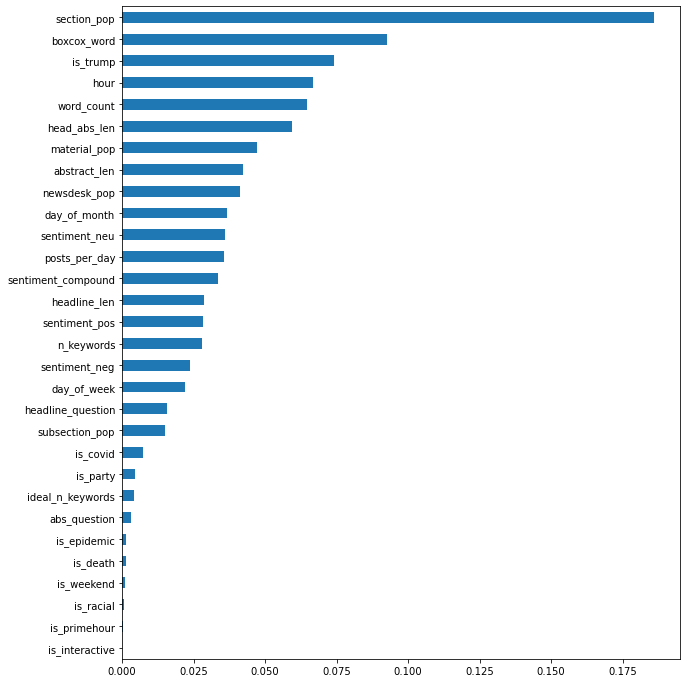

In [62]:
plt.figure(figsize=(10,12))
rf_feature_imp = pd.Series(rf_gs[1][1].feature_importances_, index=X.columns).sort_values(ascending=False)
rf_feature_imp.sort_values().plot(kind = 'barh')

### XGBoost Feature Importance

In [63]:
scores_dict = xgb_gs.steps[1][1]._Booster.get_score(importance_type='gain')

In [64]:
total_cover = pd.DataFrame(xgb_gs.steps[1][1]._Booster.get_score(importance_type='total_cover'), index=[0]) \
            .T.reset_index()
total_cover.columns = ['feature', 'total cover']
total_cover = total_cover.sort_values(by='total cover', ascending=False)

In [65]:
total_gain = pd.DataFrame(xgb_gs.steps[1][1]._Booster.get_score(importance_type='total_gain'), index=[0]) \
            .T.reset_index()
total_gain.columns = ['feature', 'total gain']
total_gain = total_gain.sort_values(by='total gain', ascending=False)

In [66]:
gain_df = pd.DataFrame(xgb_gs.steps[1][1]._Booster.get_score(importance_type='gain'), index=[0]) \
            .T.reset_index()
gain_df.columns = ['feature', 'gain']
gain_df = gain_df.sort_values(by='gain', ascending=False)

In [67]:
weight_df = pd.DataFrame(xgb_gs.steps[1][1]._Booster.get_score(importance_type='weight'), index=[0]) \
            .T.reset_index()
weight_df.columns = ['feature', 'weight']
weight_df = weight_df.sort_values(by='weight', ascending=False)

In [68]:
cover_df = pd.DataFrame(xgb_gs.steps[1][1]._Booster.get_score(importance_type='cover'), index=[0]) \
            .T.reset_index()
cover_df.columns = ['feature', 'cover']
cover_df = cover_df.sort_values(by='cover', ascending=False)

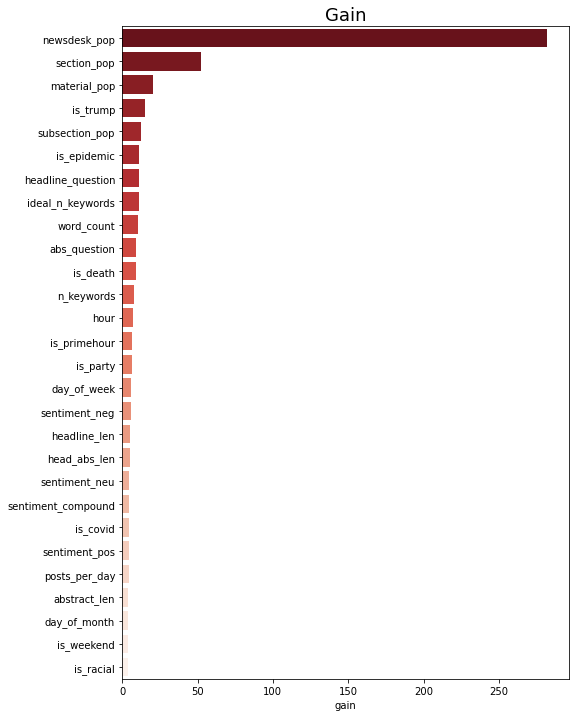

In [69]:
plt.figure(figsize=(8,12))
sns.barplot(data=gain_df, y='feature', x='gain', orient='h', palette='Reds_r')
plt.ylabel('');
plt.title('Gain', fontsize=18);

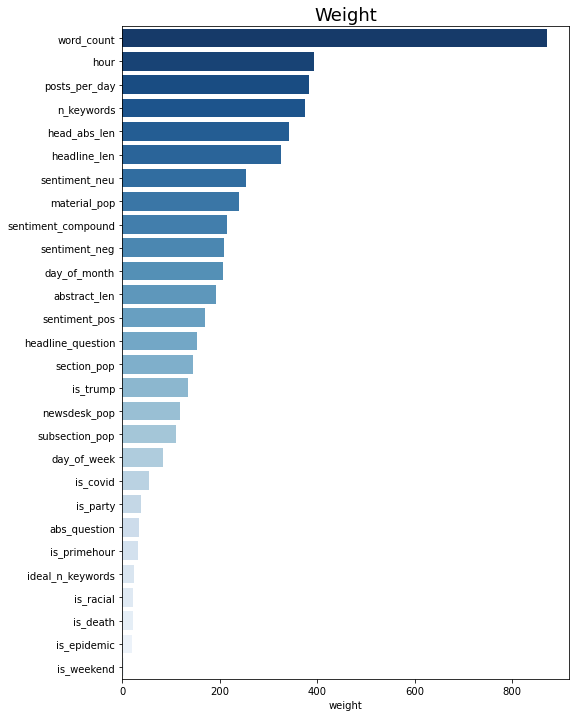

In [70]:
plt.figure(figsize=(8,12))
sns.barplot(data=weight_df, y='feature', x='weight', orient='h', palette='Blues_r')
plt.ylabel('');
plt.title('Weight', fontsize=18);

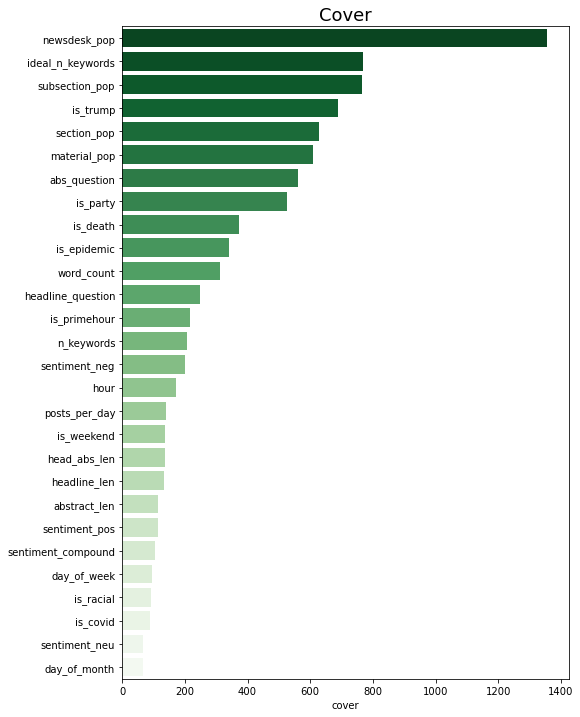

In [71]:
plt.figure(figsize=(8,12))
sns.barplot(data=cover_df, y='feature', x='cover', orient='h', palette='Greens_r')
plt.ylabel('');
plt.title('Cover', fontsize=18);

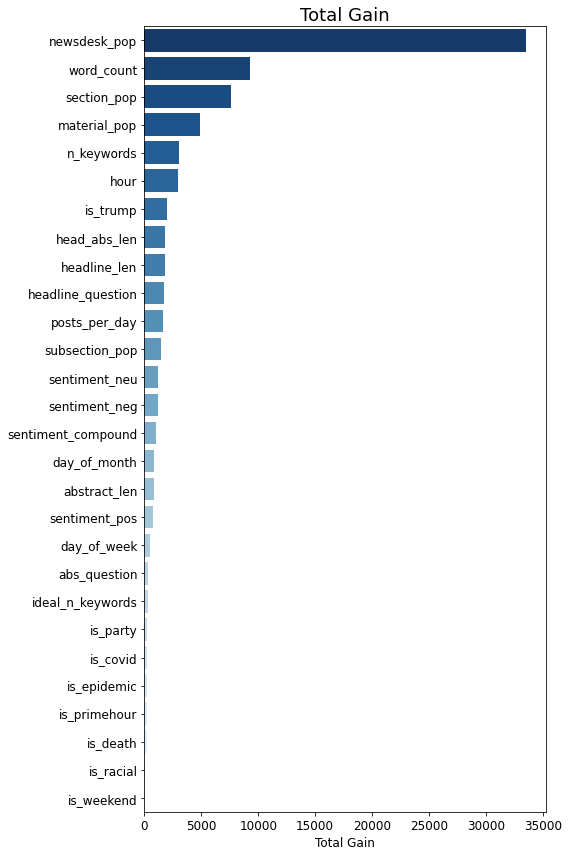

In [83]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_gain, y='feature', x='total gain', orient='h', palette='Blues_r')
plt.ylabel('');
plt.xlabel('Total Gain', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Gain', fontsize=18)
plt.tight_layout()
plt.savefig(fname='total_gain', dpi=180)

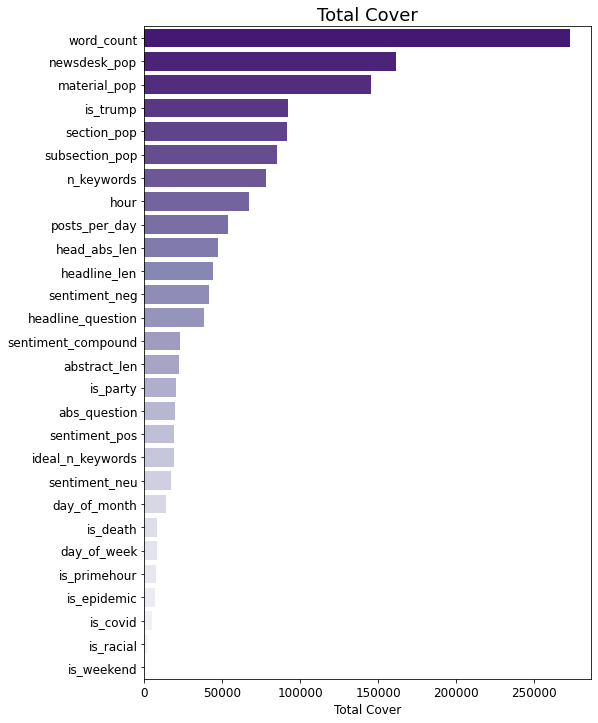

In [73]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_cover, y='feature', x='total cover', orient='h', palette='Purples_r')
plt.ylabel('');
plt.xlabel('Total Cover', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Cover', fontsize=18);